### 安装依赖

第一次执行即可，后面无需执行避免浪费时间

In [1]:
!pip install librosa==0.11.0 cffi==1.17.1

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.huaweicloud.com/repository/pypi/simple
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.2.post1
    Uninstalling librosa-0.10.2.post1:
      Successfully uninstalled librosa-0.10.2.post1

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### 解压数据集

第一次执行即可，后面无需执行避免浪费时间

Tips: 在 jupyter 中可以用 `!command` 的形式来执行终端命令，这里用 unzip 进行解压，`-q` 表示静默模式避免显示过多的输出，`-n` 表示只解压不重复的文件，避免二次执行时询问是否覆盖

In [2]:
!unzip -q -n data.zip

### 导入必要的依赖库

其中 librosa 是一个**音频处理**的库，在本实验中需要利用它来加载音频并提取音频的时序特征，其它的是深度学习常见的库

In [3]:
import os
import time
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_npu

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm  # 进度条
from torch.nn.utils.rnn import pad_sequence # 用于填充序列
from IPython.display import clear_output, Audio # 用于播放音频和清除输出

/home/service/.local/lib/python3.10/site-packages/torch_npu/utils/path_manager.py:82: UserWarning: Warning: The /usr/local/Ascend/ascend-toolkit/latest owner does not match the current user.
  warnings.warn(f"Warning: The {path} owner does not match the current user.")
/home/service/.local/lib/python3.10/site-packages/torch_npu/utils/path_manager.py:82: UserWarning: Warning: The /usr/local/Ascend/ascend-toolkit/8.0.RC3/aarch64-linux/ascend_toolkit_install.info owner does not match the current user.
  warnings.warn(f"Warning: The {path} owner does not match the current user.")


### 定义数据集

数据组织结构如下：
```text
|- data
│   |- train
|   |  |- 000.wav
|   |  `- ...
│   `-- test
|      |- 000.wav
|      `- ...
│- train.csv
`- test.csv
```

**这部分已经提供好，无需同学们完成**。注意在这里需要自定义 `collate_fn` 用于将一个 batch 中所有的音频填充到相同的长度以方便进行批量计算。

In [4]:
# ---- 数据集加载和特征提取 ----

class AudioDataset(Dataset):
    def __init__(self, dataframe, data_dir, n_mfcc=13):
        """
        Args:
            dataframe (pd.DataFrame): df contains file names and labels
            data_dir (str): data directory containing audio files
            n_mfcc (int): MFCC features count
        """
        self.dataframe = dataframe
        self.data_dir = data_dir
        self.n_mfcc = n_mfcc

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Returns:
            features (torch.Tensor): (seq_len, feature_dim)
            label (int): int
        """
        row = self.dataframe.iloc[idx]
        file_name = row['filename']
        label = row['class']  # class 列是类别名 ('dog', 'cat', 'bird')
        
        # 音频路径
        file_path = os.path.join(self.data_dir, file_name)
        
        # 加载音频并提取时序特征 (MFCC)
        y, sr = librosa.load(file_path, sr=None)
        
        # 提取 MFCC 特征
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
        mfcc = torch.tensor(mfcc.T, dtype=torch.float32)  # 转置为 (seq_len, feature_dim)
        
        # 将类别字符串映射为索引
        label_mapping = {'cat': 0, 'dog': 1, 'bird': 2}
        label = label_mapping[label]

        return mfcc, label


# 由于不同音频长度不同，需要使用自定义的 collate_fn 来将同一个 batch 中的音频 padding 到其中的最大长度
def collate_fn(batch):
    """
    for padding data with different lengths

    Args:
        batch (tuple): (features, label)

    Returns:
        padded_batch_features (torch.Tensor): (batch_size, max_seq_len, feature_dim)
        batch_labels (torch.Tensor): (batch_size,)
    """
    features = [item[0] for item in batch]  # 提取每个样本的 features
    labels = [item[1] for item in batch]    # 提取每个样本的 label

    # 对不定长序列进行 padding，填充后 shape: (batch_size, max_seq_len, feature_dim)
    padded_features = pad_sequence(features, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.long)             # 转为 Tensor

    return padded_features, labels

### 实例化 Dataset 和 DataLoader

这里需要同学们完成一些简单的操作来熟悉数据加载步骤

在云平台上，建议在 `DataLoader` 中设置 `num_workers` 来加快数据集加载速度，在 OpenI 平台上可以设置 `num_workers=16`，在华为云平台上如果使用 NPU 环境设置 `num_workers=6`，使用 CPU 环境设置 `num_workers=3`

In [5]:
# 加载训练集和测试集路径
dataset_dir = "data"
train_csv_path = f"{dataset_dir}/train.csv"
test_csv_path = f"{dataset_dir}/test.csv"
train_dir = f"{dataset_dir}/train"
test_dir = f"{dataset_dir}/test"

train_df = pd.read_csv(train_csv_path)  # 读取训练集 CSV 文件
test_df = pd.read_csv(test_csv_path)    # 读取测试集 CSV 文件

# 创建数据集
train_dataset = AudioDataset(dataframe=train_df, data_dir=train_dir)  # 创建训练集对象
test_dataset = AudioDataset(dataframe=test_df, data_dir=test_dir)     # 创建测试集对象

# 数据加载器
batch_size = 16 # Tips: 你可以根据显存来自己调整来获得最佳性能
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,          # 训练集需要打乱顺序
    collate_fn=collate_fn  # 使用自定义的填充函数
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,         # 测试集不需要打乱顺序
    collate_fn=collate_fn  # 使用相同的填充函数
)

In [6]:
# 查看下数据集，其中 class 表示类别，数据集中的类别有 cat, dog, bird 总共 3 类
train_df.head()

,filename,class
0,000.wav,bird
1,001.wav,cat
2,002.wav,bird
3,003.wav,dog
4,004.wav,bird


In [7]:
# 可以试听一下数据集中的音频文件
Audio(f"{train_dir}/002.wav")

让我们来看几个输入的 shape

In [8]:
# 查看第一个 batch 的数据形状
for i, (features, labels) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    if i >= 2:
        break

Batch 1:
Features shape: torch.Size([16, 32, 13])
Labels shape: torch.Size([16])
Batch 2:
Features shape: torch.Size([16, 32, 13])
Labels shape: torch.Size([16])
Batch 3:
Features shape: torch.Size([16, 32, 13])
Labels shape: torch.Size([16])


如下图所示，大家看到的 3 个 batch 可能 shape 不一样（如果一样也是正常现象，可以多尝试几次看看能不能刷出来不一样的），这是因为每个音频长度不同，在 `collate_fn` 中是按照 batch 中最大的长度进行填充的，不同 batch 中音频的最大长度可能不同，因此每个 batch 的 shape 会有差异。数据的 shape 为 `(batch_size, max_seq_len, feature_dim)`

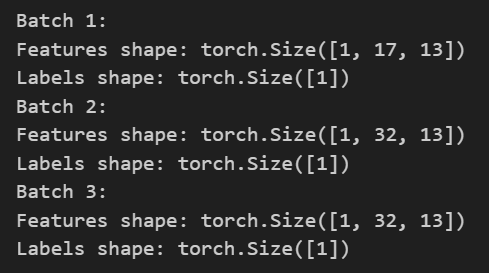

### RNN 模型定义

这部分需要同学们根据示例完成 `__init__` 中的参数定义和 `forward` 函数。

在 `__init__`，同学们可以查阅 Pytorch 文档来获得 [nn.Parameter](https://pytorch.org/docs/2.1/generated/torch.nn.parameter.Parameter.html#torch.nn.parameter.Parameter) 和 [nn.init.xavier_uniform_](https://pytorch.org/docs/2.1/nn.init.html#torch.nn.init.xavier_uniform_) 信息。其中 Xavier uniform 是一个广泛使用的初始化方式，用于初始化权重参数；偏置通常初始化为 0。

在 `forward` 根据 RNN 模型隐状态更新公式计算即可，在计算时需要注意张量的 shape 匹配问题。
$$
h_t = \text{tanh}(W_{xh} x_t + W_{hh} h_{t-1} + b_h)\\
o_t = W_{ho} h_t + b_o\\
$$

In [9]:
# 使用自定义的 RNN 模型
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        RNN model initialization

        Args:
            input_size: feature dim
            hidden_size: hidden state dim
            output_size: output dim
        """
        super(CustomRNN, self).__init__()
        
        # 参数定义
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # 定义可训练参数（使用nn.Parameter包装）
        self.W_xh = nn.Parameter(torch.empty(input_size, hidden_size))  # 输入到隐状态的权重矩阵
        self.W_hh = nn.Parameter(torch.empty(hidden_size, hidden_size)) # 隐状态递归权重矩阵
        self.b_h = nn.Parameter(torch.zeros(hidden_size))              # 隐状态偏置项
        
        self.W_ho = nn.Parameter(torch.empty(hidden_size, output_size)) # 输出层权重矩阵
        self.b_o = nn.Parameter(torch.zeros(output_size))               # 输出层偏置项
        
        # Xavier uniform 初始化权重
        nn.init.xavier_uniform_(self.W_xh)
        nn.init.xavier_uniform_(self.W_hh)
        nn.init.xavier_uniform_(self.W_ho)
        

    def forward(self, x, hidden_state=None):
        """
        Args:  
            x: (seq_len, batch_size, input_size)
            hidden_state: (batch_size, hidden_size) 

        Returns:  
            output_seq: (seq_len, batch_size, output_size)
        """
        seq_len, batch_size, _ = x.shape
        
        if hidden_state is None:  
            hidden_state = torch.zeros(batch_size, self.hidden_size).to(x.device)  # 初始化隐状态为零

        # 遍历时间步
        for t in range(seq_len):
            x_t = x[t, :, :]  # TODO: 可以在此定义中间变量，但不是必须的
            
            hidden_state = torch.tanh(
                x_t @ self.W_xh +  # [batch, input] @ [input, hidden] => [batch, hidden]
                hidden_state @ self.W_hh +  # [batch, hidden] @ [hidden, hidden] => [batch, hidden]
                self.b_h  # [hidden] 广播到 [batch, hidden]
            )
        
        logits = hidden_state @ self.W_ho + self.b_o  # [batch, hidden] @ [hidden, output] => [batch, output]
        return logits

### 训练参数设置

这部分同学们可以自行调整，建议先试用默认参数，这是助教多次尝试能够基本稳定取得预期效果的参数。

In [10]:
# 超参数设置
# Tips: 你可以自行调整来获得最佳性能
input_size = 13      # MFCC 特征数
hidden_size = 32     # 隐状态维度
output_size = 3      # 输出类别数
learning_rate = 0.005
num_epochs = 50

device = torch.device('npu')
device

device(type='npu')

### 模型初始化

由于是分类问题，损失函数当然是**交叉熵损失 (Cross Entropy Loss)**，在 Pytorch 中使用 [nn.CrossEntropyLoss](https://pytorch.org/docs/2.1/generated/torch.nn.CrossEntropyLoss.html) 实例化即可

优化器使用常见的 Adam 优化器，更多细节参见 [torch.optim.Adam](https://pytorch.org/docs/2.1/generated/torch.optim.Adam.html)。顺带一提，[Adam](https://arxiv.org/abs/1412.6980) 最近（笔者编辑时间是 2025 年 4 月）刚获得 ICLR 2025 的时间检验奖 (ICLR 2025 Test of Time Award), 作者在会上分享了 Adam 初次投稿被拒稿以及后来发邮件申诉接收的经历。

In [11]:
# 模型初始化
model = CustomRNN(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

[W compiler_depend.ts:623] Warning: expandable_segments currently defaults to false. You can enable this feature by `export PYTORCH_NPU_ALLOC_CONF = expandable_segments:True`. (function operator())


### 模型训练

这部分同学们按照提示完成即可

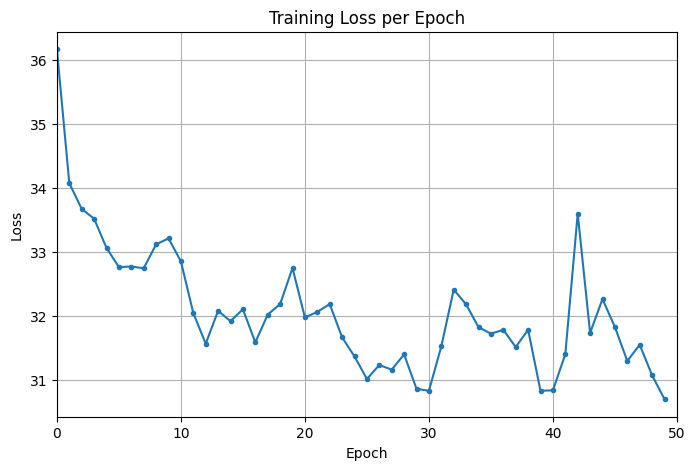

Final Loss: 30.6978
Training Time: 1594.28 seconds, 31.89 s/epoch


In [12]:
# 训练
losses = []

time_start = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for features, labels in train_loader:
        # 数据转移到设备
        features, labels = features.to(device), labels.to(device)
        
        # 调整输入形状为 (seq_len, batch_size, input_size)
        features = features.permute(1, 0, 2)  # [3,7](@ref)
        
        # 前向传播
        optimizer.zero_grad()  # 每次迭代前清除历史梯度[8,10](@ref)
        logits = model(features)  # 调用RNN模型[3,7](@ref)
        
        # 计算损失
        loss = criterion(logits, labels)
        
        # 反向传播与优化
        loss.backward()  # 自动计算梯度[8](@ref)
        optimizer.step()  # 更新参数[10](@ref)

        total_loss += loss.item()

    losses.append(total_loss)

    # 实时更新loss曲线
    clear_output(wait=True)
    plt.figure(figsize=(8, 5))
    plt.plot(range(epoch + 1), losses, marker='.')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xlim(0, num_epochs)
    plt.grid()
    plt.show()

time_end = time.time()

# 输出训练结果
print(f"Final Loss: {total_loss:.4f}")
print(f"Training Time: {time_end - time_start:.2f} seconds, {(time_end - time_start)/num_epochs:.2f} s/epoch")

### 评估

这部分根据提示完成即可

In [13]:
# 评估
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        
        # 调整输入形状为 (seq_len, batch_size, input_size)
        features = features.permute(1, 0, 2)  # [batch, seq, feat] -> [seq, batch, feat]
        
        # 前向传播
        logits = model(features)  # 输出形状 [batch_size, num_classes]
        
        # 获取预测类别（在dim=1维度取最大值的索引）
        predicted = torch.argmax(logits, dim=1)  # 形状 [batch_size]
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 34.15%


在训练部分，同学们一般观测到 loss 下降缓慢，在训练 50 个 epoch 后 loss 仍是一个较大的值（一般大于 20.0），这表明模型没有很好地学会如何对输入的音频分类。同学们如果发现 loss 曲线未收敛，可以继续增加 epoch；如果发现 loss 曲线收敛到较大的 loss，可以减少 learning_rate 并增加 epoch，但这些方案耗时较长并且精度提升少，更推荐同学们先继续往下看尝试 LSTM 模型。

在评估部分，同学门一般观测到模型在测试集上的准确率为 30%-40%，这对于一个三分类任务来说是糟糕的，不比“盲猜”好多少。

这是因为基础的 RNN 模型对长序列的学习效果不理想，容易导致**梯度消失、梯度爆炸和信息丢失**等问题。因此现在 RNN 实际应用的较少，一般会采用其改进结构 LSTM（Long Short‐Term Memory，长短期记忆网络）或 GRU（Gated Recurrent Units，门控循环单元）。下面我们以 LSTM 为例来实现其改进版本。

### LSTM 模型实现

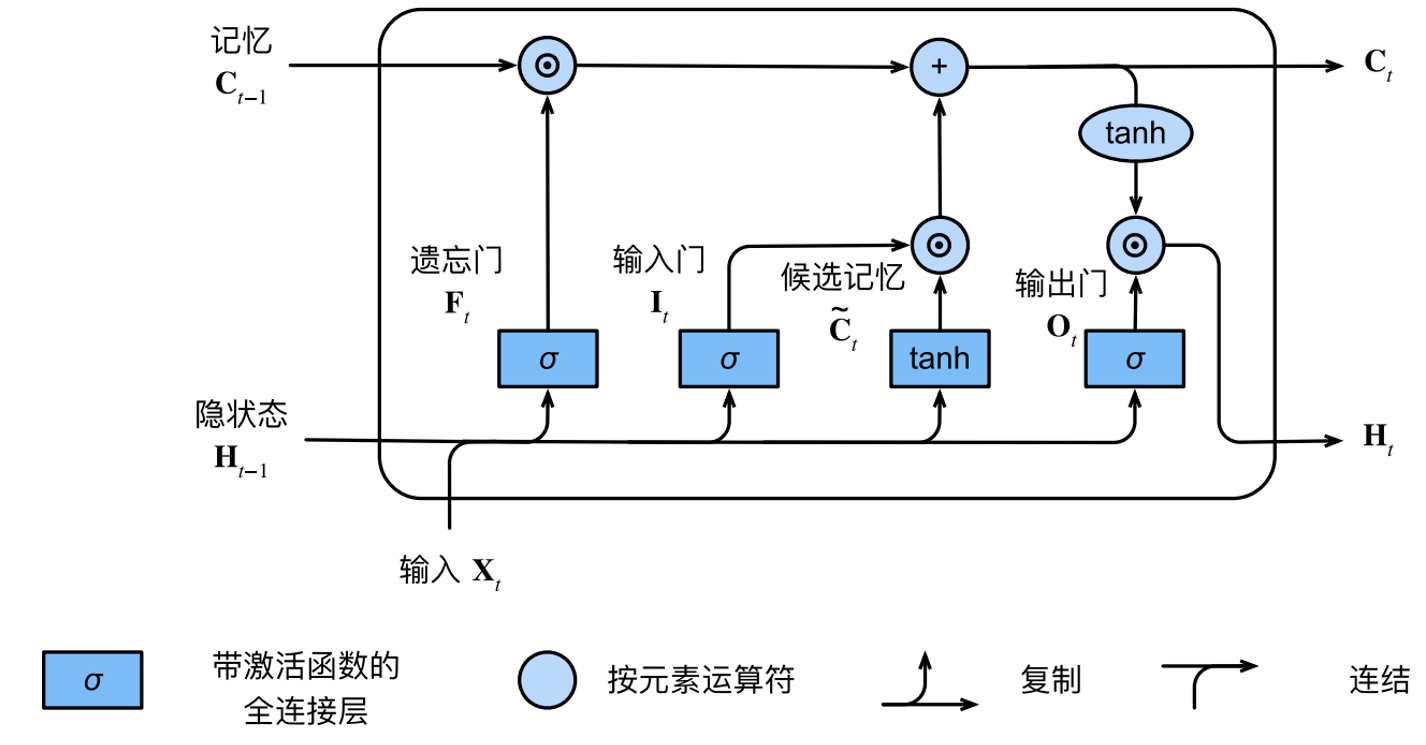

图片来源：[《动手学深度学习》](https://github.com/d2l-ai/d2l-zh)

LSTM 块结构如上图所示，我们只需要将前面的 RNN 块替换为 LSTM 块即可，同学们需要完成下面 `CustomLSTM` 中空缺的部分。

LSTM 的更新公式如下：
$$
f_t = \text{sigmoid}(W_{xf} x_t + W_{hf} h_{t - 1} + b_f)\\
i_t = \text{sigmoid}(W_{xi} x_t + W_{hi} h_{t - 1} + b_i)\\
\tilde{c_t} = \text{tanh}(W_{xc} x_t + W_{hc} h_{t - 1} + b_c)\\
c_t = f_t \odot c_{t - 1} + i_t \odot \tilde{c_t}\\
o_t = \text{sigmoid}(W_{xo} x_t + W_{ho} h_{t - 1} + b_o)\\
h_t = o_t \odot \text{tanh}(c_t)
$$
其中 $f_t,\ i_t,\ o_t$ 分别称为**遗忘门、输入门和输出门**，它们的取值范围是 $(0, 1)$，分别控制保留多少过去的记忆元 $c_{t - 1}$ 的内容、采用多少来自 $\tilde{c_t}$ 的新数据和 $c_t$ 中输出多少信息到当前的隐藏状态；$c_t$ 是 LSTM 引入的一种特殊隐状态，称为记忆，shape 和隐状态 $h_t$ 相同；$\tilde{c_t}$ 称为候选记忆。

同学们可以阅读 LSTM 的原论文 [Long short-term memory](https://ieeexplore.ieee.org/abstract/document/6795963/)。

最后，我们将隐状态 $h_t$ 经过一个线性层来完成 3 分类任务。这里使用隐状态是因为它代表当前时间步 LSTM 的输出，已经是对所有输入信息的“综合表达”，是 LSTM 设计用作“输出”的部分；而记忆 $c_t$ 更像是 LSTM 内部长期记忆的“仓库”，主要供网络内部后续时刻再利用，并非直接设计为外部特征。这里直接使用 [nn.Linear](https://pytorch.org/docs/2.1/generated/torch.nn.Linear.html) 作为线性层。

In [14]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # 遗忘门参数[1,7](@ref)
        self.W_xf = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hf = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.zeros(hidden_size))

        # 输入门参数[1,9](@ref)
        self.W_xi = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hi = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.zeros(hidden_size))

        # 候选记忆单元参数[1,6](@ref)
        self.W_xc = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hc = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

        # 输出门参数[3,7](@ref)
        self.W_xo = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.W_ho = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.zeros(hidden_size))

        # 输出层参数[8](@ref)
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)

        self.init_weights()

    def init_weights(self):
        """Xavier初始化权重矩阵[1,7](@ref)"""
        for param in [self.W_xf, self.W_hf, self.W_xi, self.W_hi, 
                     self.W_xc, self.W_hc, self.W_xo, self.W_ho]:
            nn.init.xavier_uniform_(param)

    def forward(self, x):
        seq_len, batch_size, _ = x.shape
        device = x.device

        # 初始化隐状态和细胞状态[3,7](@ref)
        h_t = torch.zeros(batch_size, self.hidden_size).to(device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(device)

        for t in range(seq_len):
            x_t = x[t, :, :]  # 当前时间步输入 (batch, input_size)

            # 遗忘门计算[1,9](@ref)
            f_t = torch.sigmoid(
                x_t @ self.W_xf + 
                h_t @ self.W_hf + 
                self.b_f
            )

            # 输入门计算[1,6](@ref)
            i_t = torch.sigmoid(
                x_t @ self.W_xi + 
                h_t @ self.W_hi + 
                self.b_i
            )

            # 候选记忆单元[1,10](@ref)
            c_hat_t = torch.tanh(
                x_t @ self.W_xc + 
                h_t @ self.W_hc + 
                self.b_c
            )

            # 更新细胞状态[1,9](@ref)
            c_t = f_t * c_t + i_t * c_hat_t

            # 输出门计算[3,7](@ref)
            o_t = torch.sigmoid(
                x_t @ self.W_xo + 
                h_t @ self.W_ho + 
                self.b_o
            )

            # 更新隐状态[1,6](@ref)
            h_t = o_t * torch.tanh(c_t)

        logits = self.fc(h_t)
        return logits

In [15]:
# 模型初始化
lstm_model = CustomLSTM(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

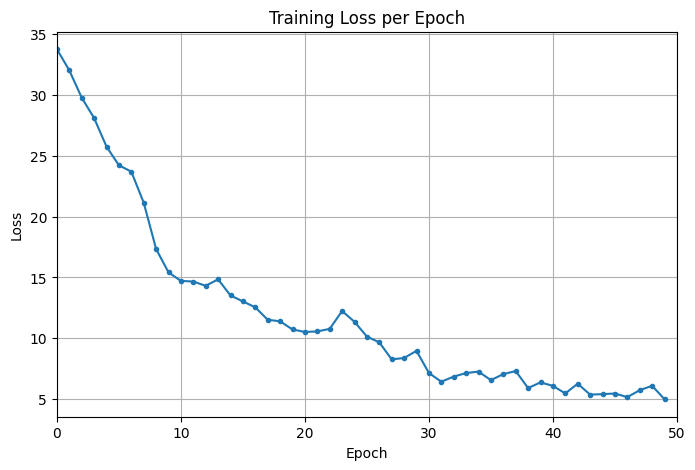

Final Loss: 4.9945
Training Time: 1718.28 seconds, 34.37 s/epoch


In [16]:
# 训练
losses = []

time_start = time.time()
for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0
    
    for features, labels in train_loader:
        # 数据转移到设备
        features, labels = features.to(device), labels.to(device)
        
        # 调整输入形状为(seq_len, batch_size, input_size)[1,6](@ref)
        features = features.permute(1, 0, 2)  # 将batch维度与seq_len交换
        
        # 前向传播
        optimizer.zero_grad()  # 清零梯度[7](@ref)
        logits = lstm_model(features)  # 模型前向计算[2,6](@ref)
        
        # 计算损失
        loss = criterion(logits, labels)
        
        # 反向传播与优化
        loss.backward()  # 计算梯度[3](@ref)
        optimizer.step()  # 参数更新[7](@ref)

        total_loss += loss.item()

    losses.append(total_loss)

    # 实时更新loss曲线[1](@ref)
    clear_output(wait=True)
    plt.figure(figsize=(8, 5))
    plt.plot(range(epoch + 1), losses, marker='.')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xlim(0, num_epochs)
    plt.grid()
    plt.show()

time_end = time.time()

# 输出训练结果[1,7](@ref)
print(f"Final Loss: {total_loss:.4f}")
print(f"Training Time: {time_end - time_start:.2f} seconds, {(time_end - time_start)/max(1, num_epochs):.2f} s/epoch")

In [17]:
# 评估
lstm_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        
        # 调整输入形状为 (seq_len, batch_size, input_size)[1,3](@ref)
        features = features.permute(1, 0, 2)  # 将维度从[batch, seq, feat]转为[seq, batch, feat]
        
        # 前向传播[1,6](@ref)
        logits = lstm_model(features)  # 输出形状 [batch_size, num_classes]
        
        # 获取预测类别[3,4](@ref)
        predicted = torch.argmax(logits, dim=1)  # 在分类维度取最大值
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 85.37%


使用 LSTM 后，同学们一般在训练阶段能观测到 loss 下降更为迅速，在训练 50 个 epoch 后 loss 下降到一个较低的水平（一般在 5.0 以下），并且在测试集上准确率能够达到 85%-95%，这表明 LSTM 模型学会了如何进行音频分类。